# 0. 라이브러리 및 데이터 로드
- train.csv 불러오기
- 기본 구조 및 결측/기초 통계 확인


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 한글 폰트 설정이 필요하면 아래처럼 추가 (환경에 맞게 수정)
# plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows 예시
# plt.rcParams['axes.unicode_minus'] = False

# 경로는 환경에 맞게 수정
df = pd.read_csv("train.csv")

print("데이터 컬럼:", df.columns.tolist())
print(df.head())
print(df.info())

# 날짜 컬럼 생성 (year, month 기반)
df['date'] = pd.to_datetime(dict(year=df['year'], month=df['month'], day=1))

print(df[['value', 'weight', 'quantity']].describe())
print("value==0 개수:", (df['value'] == 0).sum())
print("weight==0 개수:", (df['weight'] == 0).sum())
print("quantity==0 개수:", (df['quantity'] == 0).sum())


데이터 컬럼: ['item_id', 'year', 'month', 'seq', 'type', 'hs4', 'weight', 'quantity', 'value']
    item_id  year  month  seq  type   hs4    weight  quantity     value
0  DEWLVASR  2022      1  1.0     1  3038   14858.0       0.0   32688.0
1  ELQGMQWE  2022      1  1.0     1  2002   62195.0       0.0  110617.0
2  AHMDUILJ  2022      1  1.0     1  2102   18426.0       0.0   72766.0
3  XIPPENFQ  2022      1  1.0     1  2501   20426.0       0.0   11172.0
4  FTSVTTSR  2022      1  1.0     1  2529  248000.0       0.0  143004.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10836 entries, 0 to 10835
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   item_id   10836 non-null  object 
 1   year      10836 non-null  int64  
 2   month     10836 non-null  int64  
 3   seq       10836 non-null  float64
 4   type      10836 non-null  int64  
 5   hs4       10836 non-null  int64  
 6   weight    10836 non-null  float64
 7   quantity  1083

## 3-1. 월별 전체 value / weight / quantity 총합 트렌드

- year, month 기준으로 그룹화하여 합계를 계산
- date 컬럼을 x축으로 사용해 라인 그래프 그리기


[월별 합계 데이터 예시]
   year  month        value       weight   quantity       date
0  2022      1  696534744.0  444948842.0  3816510.0 2022-01-01
1  2022      2  538911879.0  310043203.0  4150202.0 2022-02-01
2  2022      3  607177801.0  335892690.0  4338440.0 2022-03-01
3  2022      4  591170783.0  326773243.0  3693557.0 2022-04-01
4  2022      5  626300913.0  312303280.0  3121137.0 2022-05-01


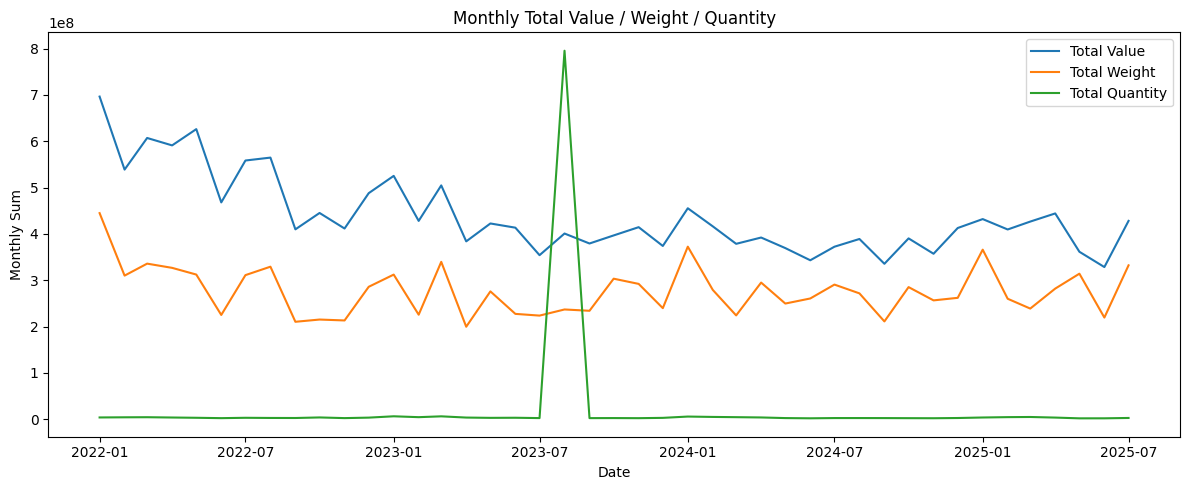

In [4]:
# 월별 합계
monthly_sum = (
    df.groupby(['year', 'month'], as_index=False)[['value', 'weight', 'quantity']]
      .sum()
)

# 라인 플롯용 날짜 컬럼
monthly_sum['date'] = pd.to_datetime(
    dict(year=monthly_sum['year'], month=monthly_sum['month'], day=1)
)

print("[월별 합계 데이터 예시]")
print(monthly_sum.head())

plt.figure(figsize=(12, 5))
plt.plot(monthly_sum['date'], monthly_sum['value'], label='Total Value')
plt.plot(monthly_sum['date'], monthly_sum['weight'], label='Total Weight')
plt.plot(monthly_sum['date'], monthly_sum['quantity'], label='Total Quantity')

plt.xlabel("Date")
plt.ylabel("Monthly Sum")
plt.title("Monthly Total Value / Weight / Quantity")
plt.legend()
plt.tight_layout()
plt.show()


In [5]:
# 월별 quantity만 시계열 정렬
ms = monthly_sum.sort_values("date").reset_index(drop=True)

# 전월 대비 증가 비율 계산
ms["qty_prev"] = ms["quantity"].shift(1)
ms["qty_ratio"] = ms["quantity"] / ms["qty_prev"]

# 폭등 기준: 전월 대비 5배 이상 증가 (필요시 조정 가능)
spike = ms[ms["qty_ratio"] > 5]

spike


,year,month,value,weight,quantity,date,qty_prev,qty_ratio
19,2023,8,400904085.0,236941429.0,795564679.0,2023-08-01,2451044.0,324.581965


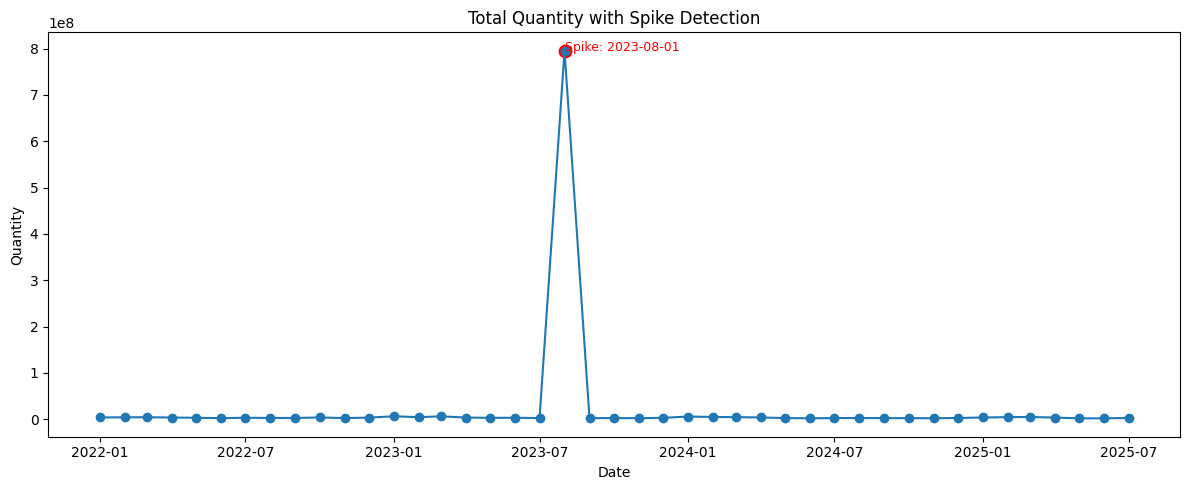

In [6]:
plt.figure(figsize=(12, 5))
plt.plot(ms['date'], ms['quantity'], marker='o')

# spike 지점에 색과 텍스트 표시
for _, row in spike.iterrows():
    plt.scatter(row['date'], row['quantity'], color='red', s=80)
    plt.text(row['date'], row['quantity'], f"Spike: {row['date'].date()}",
             fontsize=9, color='red', ha='left')

plt.title("Total Quantity with Spike Detection")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.tight_layout()
plt.show()


In [7]:
# 2023년 8월 데이터만 필터
df_july_2023 = df[(df['year'] == 2023) & (df['month'] == 8)]

# quantity 상위 아이템 보기
df_july_2023.sort_values('quantity', ascending=False).head(20)


,item_id,year,month,seq,type,hs4,weight,quantity,value,date
4796,QVLMOEYE,2023,8,1.0,1,4202,3197.0,792598955.0,660801.0,2023-08-01
4978,CCLHWFWF,2023,8,3.0,1,6211,346734.0,798661.0,9268511.0,2023-08-01
4807,OKMBFVKS,2023,8,1.0,1,5705,312604.0,609401.0,602762.0,2023-08-01
4810,CCLHWFWF,2023,8,1.0,1,6211,216333.0,490938.0,7696693.0,2023-08-01
4890,CCLHWFWF,2023,8,2.0,1,6211,200146.0,483767.0,6264649.0,2023-08-01
4975,OKMBFVKS,2023,8,3.0,1,5705,464731.0,329344.0,1241411.0,2023-08-01
4887,OKMBFVKS,2023,8,2.0,1,5705,269943.0,163716.0,492854.0,2023-08-01
4972,AXULOHBQ,2023,8,3.0,1,5515,9564.0,27526.0,71120.0,2023-08-01
4804,AXULOHBQ,2023,8,1.0,1,5515,3123.0,8809.0,66957.0,2023-08-01
4961,QVLMOEYE,2023,8,3.0,1,4202,6622.0,7383.0,606579.0,2023-08-01


## 조건 기반으로 이상치(row) 제거

In [8]:
mask_outlier = (
    (df['hs4'] == 4202) &
    (df['item_id'] == 'QVLMOEYE') &
    (df['year'] == 2023) &
    (df['month'] == 8) &
    (df['quantity'] > 1e7)
)

df_clean = df[~mask_outlier].copy()

[월별 합계 데이터 예시]
   year  month        value       weight   quantity       date
0  2022      1  696534744.0  444948842.0  3816510.0 2022-01-01
1  2022      2  538911879.0  310043203.0  4150202.0 2022-02-01
2  2022      3  607177801.0  335892690.0  4338440.0 2022-03-01
3  2022      4  591170783.0  326773243.0  3693557.0 2022-04-01
4  2022      5  626300913.0  312303280.0  3121137.0 2022-05-01


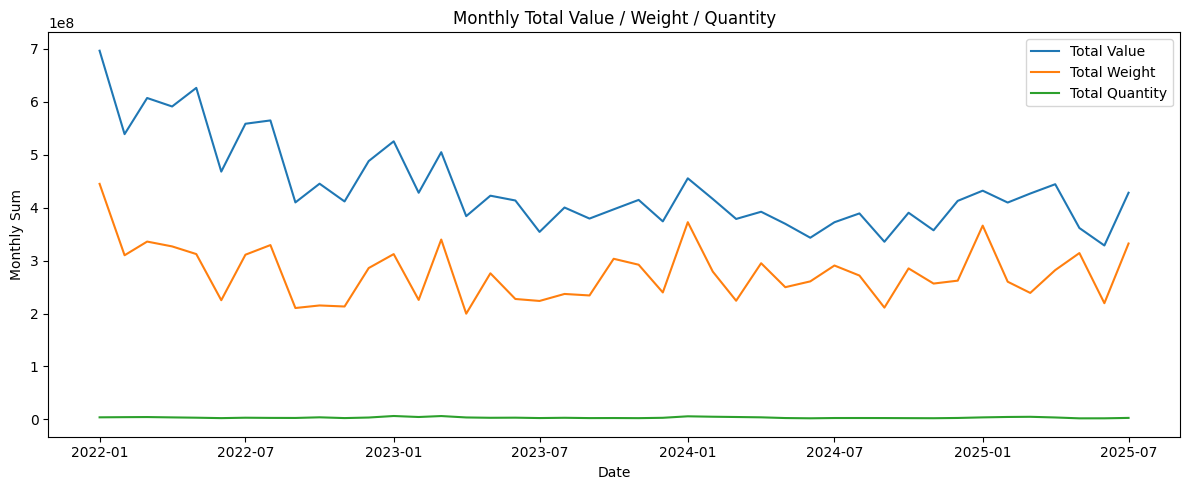

In [9]:
# 월별 합계
monthly_sum = (
    df_clean.groupby(['year', 'month'], as_index=False)[['value', 'weight', 'quantity']]
      .sum()
)

# 라인 플롯용 날짜 컬럼
monthly_sum['date'] = pd.to_datetime(
    dict(year=monthly_sum['year'], month=monthly_sum['month'], day=1)
)

print("[월별 합계 데이터 예시]")
print(monthly_sum.head())

plt.figure(figsize=(12, 5))
plt.plot(monthly_sum['date'], monthly_sum['value'], label='Total Value')
plt.plot(monthly_sum['date'], monthly_sum['weight'], label='Total Weight')
plt.plot(monthly_sum['date'], monthly_sum['quantity'], label='Total Quantity')

plt.xlabel("Date")
plt.ylabel("Monthly Sum")
plt.title("Monthly Total Value / Weight / Quantity")
plt.legend()
plt.tight_layout()
plt.show()



## 3-2. 연도별 합계 및 평균 변화

- year 기준으로 그룹화하여 value/weight/quantity 합계 및 평균 계산
- 연도별 합계 라인 그래프를 통해 추세 확인


[연도별 합계]
   year         value        weight     quantity
0  2022  6.406476e+09  3.520162e+09   39626994.0
1  2023  4.998317e+09  3.110771e+09  834808576.0
2  2024  4.612925e+09  3.258580e+09   37929189.0
3  2025  2.830876e+09  2.012886e+09   23190720.0

[연도별 평균]
   year         value        weight       quantity
0  2022  2.139772e+06  1.175739e+06   13235.468938
1  2023  1.650699e+06  1.027335e+06  275696.359313
2  2024  1.515914e+06  1.070844e+06   12464.406507
3  2025  1.598462e+06  1.136582e+06   13094.703557


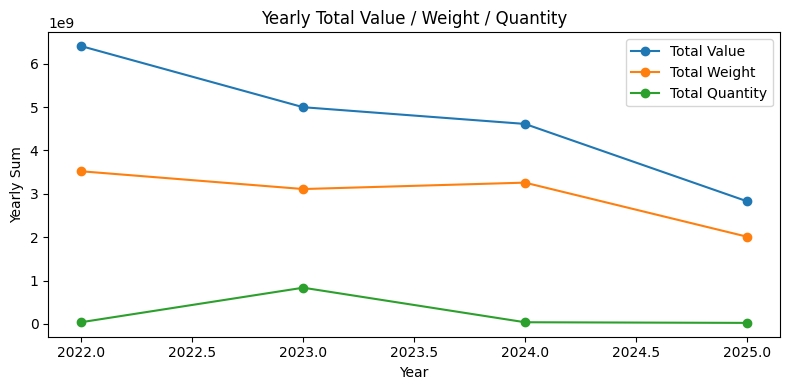

In [10]:
# 연도별 합계와 평균
yearly_sum = (
    df.groupby('year', as_index=False)[['value', 'weight', 'quantity']]
      .sum()
)
yearly_mean = (
    df.groupby('year', as_index=False)[['value', 'weight', 'quantity']]
      .mean()
)

print("[연도별 합계]")
print(yearly_sum)

print("\n[연도별 평균]")
print(yearly_mean)

# 연도별 합계 라인 플롯
plt.figure(figsize=(8, 4))
plt.plot(yearly_sum['year'], yearly_sum['value'], marker='o', label='Total Value')
plt.plot(yearly_sum['year'], yearly_sum['weight'], marker='o', label='Total Weight')
plt.plot(yearly_sum['year'], yearly_sum['quantity'], marker='o', label='Total Quantity')

plt.xlabel("Year")
plt.ylabel("Yearly Sum")
plt.title("Yearly Total Value / Weight / Quantity")
plt.legend()
plt.tight_layout()
plt.show()


[연도별 합계]
   year         value        weight    quantity
0  2022  6.406476e+09  3.520162e+09  39626994.0
1  2023  4.997657e+09  3.110768e+09  42209621.0
2  2024  4.612925e+09  3.258580e+09  37929189.0
3  2025  2.830876e+09  2.012886e+09  23190720.0

[연도별 평균]
   year         value        weight      quantity
0  2022  2.139772e+06  1.175739e+06  13235.468938
1  2023  1.651026e+06  1.027673e+06  13944.374298
2  2024  1.515914e+06  1.070844e+06  12464.406507
3  2025  1.598462e+06  1.136582e+06  13094.703557


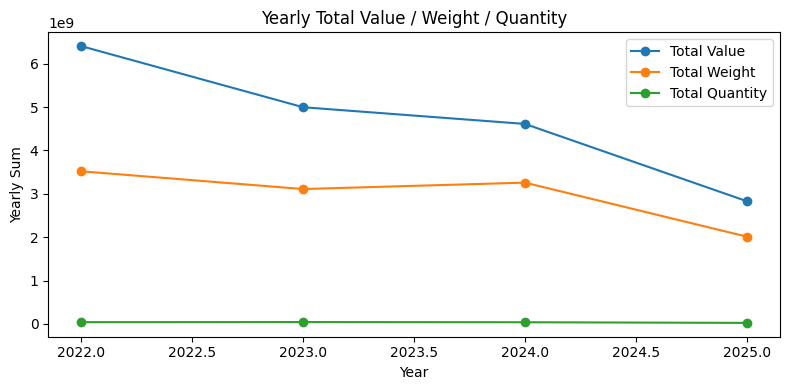

In [11]:
# 연도별 합계와 평균
yearly_sum = (
    df_clean.groupby('year', as_index=False)[['value', 'weight', 'quantity']]
      .sum()
)
yearly_mean = (
    df_clean.groupby('year', as_index=False)[['value', 'weight', 'quantity']]
      .mean()
)

print("[연도별 합계]")
print(yearly_sum)

print("\n[연도별 평균]")
print(yearly_mean)

# 연도별 합계 라인 플롯
plt.figure(figsize=(8, 4))
plt.plot(yearly_sum['year'], yearly_sum['value'], marker='o', label='Total Value')
plt.plot(yearly_sum['year'], yearly_sum['weight'], marker='o', label='Total Weight')
plt.plot(yearly_sum['year'], yearly_sum['quantity'], marker='o', label='Total Quantity')

plt.xlabel("Year")
plt.ylabel("Yearly Sum")
plt.title("Yearly Total Value / Weight / Quantity")
plt.legend()
plt.tight_layout()
plt.show()


## 3-3. 월별 계절성(seasonality) 분석

- 연도를 무시하고 month 기준으로 평균을 계산
- 특정 달에 반복적으로 값이 높은지/낮은지 확인


[월별 평균 패턴 (seasonality 후보)]
    month         value        weight      quantity
0       1  2.128557e+06  1.509324e+06  1.979018e+04
1       2  1.754505e+06  1.051810e+06  1.765162e+04
2       3  1.923094e+06  1.142052e+06  1.987640e+04
3       4  1.797278e+06  1.094653e+06  1.452386e+04
4       5  1.772791e+06  1.147578e+06  1.041085e+04
5       6  1.553303e+06  9.326956e+05  9.445794e+03
6       7  1.658586e+06  1.120719e+06  1.044116e+04
7       8  1.823419e+06  1.127790e+06  1.077837e+06
8       9  1.485947e+06  8.660655e+05  9.878915e+03
9      10  1.658765e+06  1.081829e+06  1.160774e+04
10     11  1.555285e+06  1.001276e+06  8.955857e+03
11     12  1.640808e+06  1.013870e+06  1.159758e+04


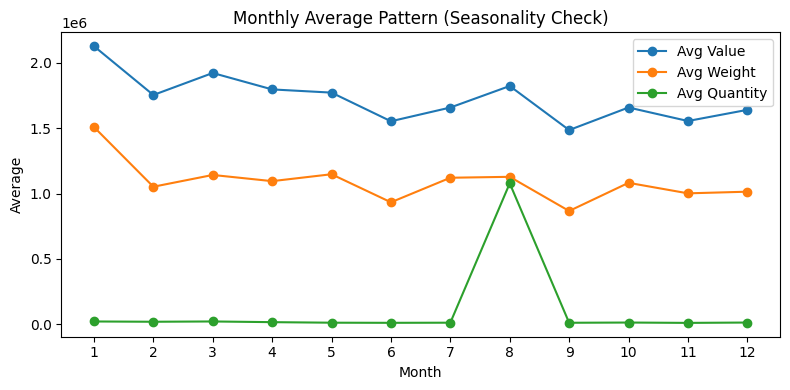

In [32]:
monthly_pattern = (
    df.groupby('month', as_index=False)[['value', 'weight', 'quantity']]
      .mean()
)

print("[월별 평균 패턴 (seasonality 후보)]")
print(monthly_pattern)

plt.figure(figsize=(8, 4))
plt.plot(monthly_pattern['month'], monthly_pattern['value'], marker='o', label='Avg Value')
plt.plot(monthly_pattern['month'], monthly_pattern['weight'], marker='o', label='Avg Weight')
plt.plot(monthly_pattern['month'], monthly_pattern['quantity'], marker='o', label='Avg Quantity')

plt.xticks(range(1, 13))
plt.xlabel("Month")
plt.ylabel("Average")
plt.title("Monthly Average Pattern (Seasonality Check)")
plt.legend()
plt.tight_layout()
plt.show()


[월별 평균 패턴 (seasonality 후보)]
    month         value        weight      quantity
0       1  2.128557e+06  1.509324e+06  19790.177598
1       2  1.754505e+06  1.051810e+06  17651.624266
2       3  1.923094e+06  1.142052e+06  19876.404213
3       4  1.797278e+06  1.094653e+06  14523.864087
4       5  1.772791e+06  1.147578e+06  10410.853586
5       6  1.553303e+06  9.326956e+05   9445.794000
6       7  1.658586e+06  1.120719e+06  10441.163601
7       8  1.824986e+06  1.129306e+06  11097.084906
8       9  1.485947e+06  8.660655e+05   9878.915456
9      10  1.658765e+06  1.081829e+06  11607.741588
10     11  1.555285e+06  1.001276e+06   8955.856767
11     12  1.640808e+06  1.013870e+06  11597.580438


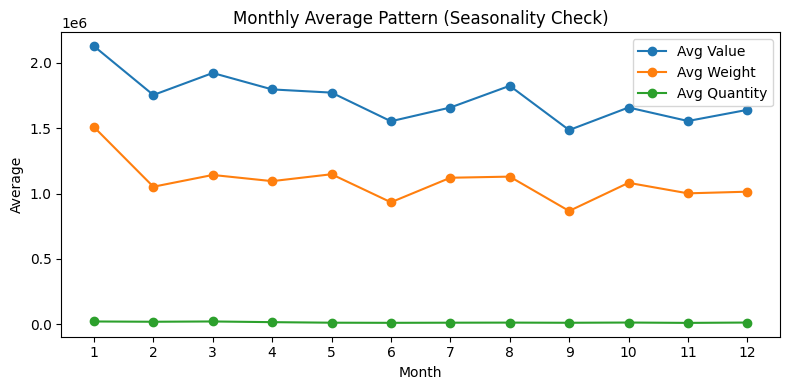

In [35]:
monthly_pattern = (
    df_clean.groupby('month', as_index=False)[['value', 'weight', 'quantity']]
      .mean()
)

print("[월별 평균 패턴 (seasonality 후보)]")
print(monthly_pattern)

plt.figure(figsize=(8, 4))
plt.plot(monthly_pattern['month'], monthly_pattern['value'], marker='o', label='Avg Value')
plt.plot(monthly_pattern['month'], monthly_pattern['weight'], marker='o', label='Avg Weight')
plt.plot(monthly_pattern['month'], monthly_pattern['quantity'], marker='o', label='Avg Quantity')

plt.xticks(range(1, 13))
plt.xlabel("Month")
plt.ylabel("Average")
plt.title("Monthly Average Pattern (Seasonality Check)")
plt.legend()
plt.tight_layout()
plt.show()


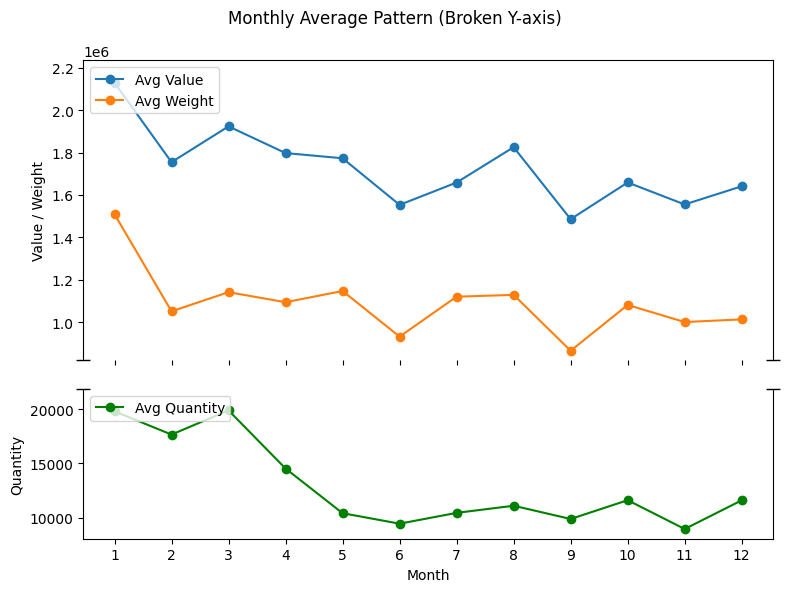

In [42]:
import matplotlib.pyplot as plt

x = monthly_pattern['month']
v = monthly_pattern['value']
w = monthly_pattern['weight']
q = monthly_pattern['quantity']

fig, (ax_upper, ax_lower) = plt.subplots(
    2, 1, sharex=True, figsize=(8, 6),
    gridspec_kw={'height_ratios': [2, 1]}
)

# -----------------------------
# 1) 위쪽 축: value, weight
# -----------------------------
ax_upper.plot(x, v, marker='o', label='Avg Value')
ax_upper.plot(x, w, marker='o', label='Avg Weight')

# weight가 안 짤리도록 ymin 자동 조정
upper_min = min(v.min(), w.min()) * 0.95   # 아래 여유
upper_max = max(v.max(), w.max()) * 1.05   # 위 여유
ax_upper.set_ylim(upper_min, upper_max)

ax_upper.legend(loc='upper left')
ax_upper.set_ylabel("Value / Weight")

# -----------------------------
# 2) 아래쪽 축: quantity
# -----------------------------
ax_lower.plot(x, q, marker='o', color='green', label='Avg Quantity')

ax_lower.set_ylim(q.min() * 0.9, q.max() * 1.1)
ax_lower.set_ylabel("Quantity")
ax_lower.legend(loc='upper left')

# -----------------------------
# 3) Broken-axis 물결 표시
# -----------------------------
ax_upper.spines['bottom'].set_visible(False)
ax_lower.spines['top'].set_visible(False)

d = .005
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=10,
              linestyle='none', color='k', mec='k', mew=1, clip_on=False)

ax_upper.plot([0, 1], [0, 0], transform=ax_upper.transAxes, **kwargs)
ax_lower.plot([0, 1], [1, 1], transform=ax_lower.transAxes, **kwargs)

# -----------------------------
# X축
# -----------------------------
ax_lower.set_xticks(range(1, 13))
ax_lower.set_xlabel("Month")

plt.suptitle("Monthly Average Pattern (Broken Y-axis)")
plt.tight_layout()
plt.show()


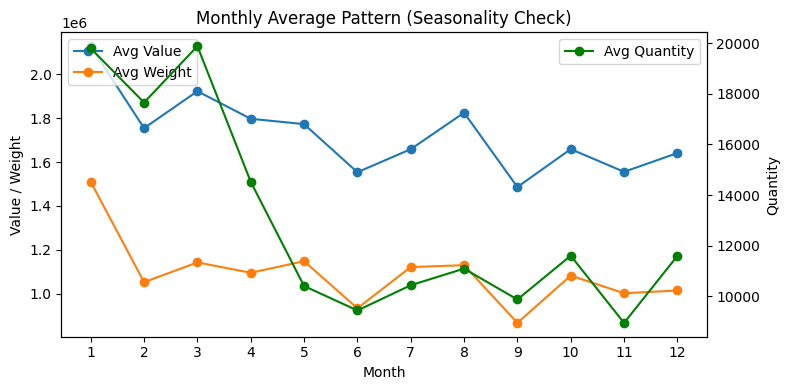

In [38]:
fig, ax1 = plt.subplots(figsize=(8, 4))

# ---- Left Y-axis for value and weight ----
ax1.plot(monthly_pattern['month'], monthly_pattern['value'], marker='o', label='Avg Value')
ax1.plot(monthly_pattern['month'], monthly_pattern['weight'], marker='o', label='Avg Weight')

ax1.set_xlabel("Month")
ax1.set_ylabel("Value / Weight")
ax1.set_xticks(range(1, 13))
ax1.legend(loc='upper left')

# ---- Right Y-axis for quantity ----
ax2 = ax1.twinx()
ax2.plot(monthly_pattern['month'], monthly_pattern['quantity'], color='green', marker='o', label='Avg Quantity')

ax2.set_ylabel("Quantity")
ax2.legend(loc='upper right')

plt.title("Monthly Average Pattern (Seasonality Check)")
plt.tight_layout()
plt.show()


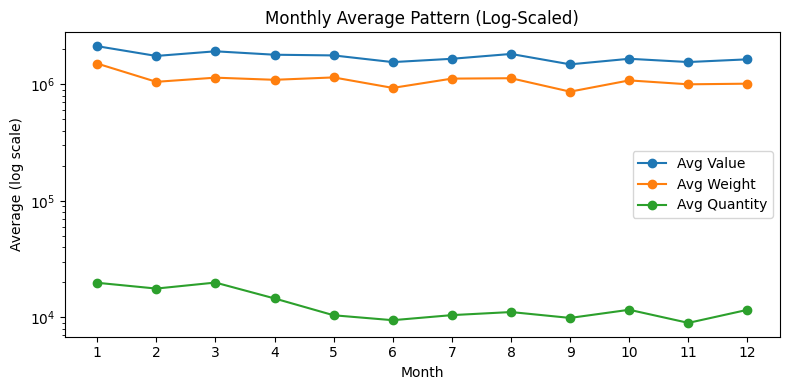

In [39]:
plt.figure(figsize=(8,4))

plt.plot(monthly_pattern['month'], monthly_pattern['value'], marker='o', label='Avg Value')
plt.plot(monthly_pattern['month'], monthly_pattern['weight'], marker='o', label='Avg Weight')
plt.plot(monthly_pattern['month'], monthly_pattern['quantity'], marker='o', label='Avg Quantity')

plt.yscale('log')   # ★ 로그 스케일
plt.xticks(range(1, 13))

plt.xlabel("Month")
plt.ylabel("Average (log scale)")
plt.title("Monthly Average Pattern (Log-Scaled)")
plt.legend()
plt.tight_layout()
plt.show()


## 3-4. 연도별 전년 대비 변화율

- 연도별 합계를 기준으로 전년 대비 변화율(pct_change) 계산
- "2024년 value는 전년 대비 몇 % 증가/감소"와 같은 해석에 활용


In [41]:
# df_clean을 사용한 yearly_sum이 있는지 확인, 없으면 생성
if 'yearly_sum' not in locals() or 'yearly_sum' not in globals():
    yearly_sum = (
        df_clean.groupby('year', as_index=False)[['value', 'weight', 'quantity']]
          .sum()
    )

yearly_sum_sorted = yearly_sum.sort_values('year').reset_index(drop=True)
yearly_sum_sorted['value_growth_rate'] = yearly_sum_sorted['value'].pct_change()
yearly_sum_sorted['weight_growth_rate'] = yearly_sum_sorted['weight'].pct_change()
yearly_sum_sorted['quantity_growth_rate'] = yearly_sum_sorted['quantity'].pct_change()

print("[연도별 전년 대비 변화율]")
print(yearly_sum_sorted[['year',
                         'value_growth_rate',
                         'weight_growth_rate',
                         'quantity_growth_rate']])


[연도별 전년 대비 변화율]
   year  value_growth_rate  weight_growth_rate  quantity_growth_rate
0  2022                NaN                 NaN                   NaN
1  2023          -0.219906           -0.116300              0.065173
2  2024          -0.076982            0.047516             -0.101409
3  2025          -0.386316           -0.382281             -0.388579


# 4번 파트: pairwise feature relationship 분석

## 4-0. 산점도용 샘플링

- 전체 데이터가 크면 산점도 그릴 때 느릴 수 있으므로
- 최대 5,000개 정도만 샘플링하여 시각화


In [15]:
sample_size = 10836
if len(df_clean) > sample_size:
    df_plot = df_clean.sample(sample_size, random_state=42)
else:
    df_plot = df_clean.copy()

print("산점도에 사용할 샘플 크기:", len(df_plot))


산점도에 사용할 샘플 크기: 10835


## 4-1. value vs weight 산점도

- 전체적으로 value와 weight가 어떤 관계를 가지는지 시각적으로 확인


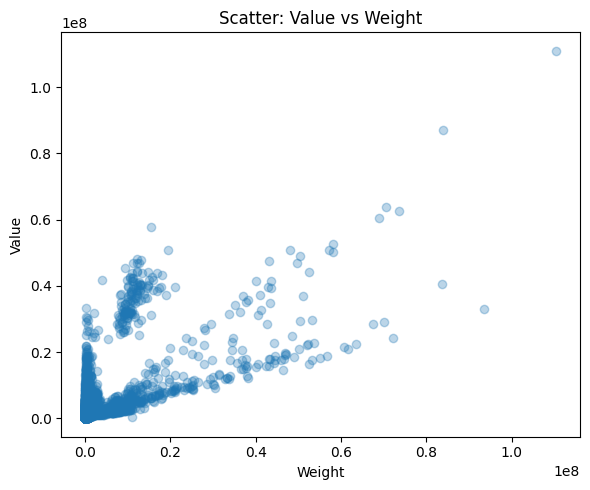

In [16]:
plt.figure(figsize=(6, 5))
plt.scatter(df_plot['weight'], df_plot['value'], alpha=0.3)
plt.xlabel("Weight")
plt.ylabel("Value")
plt.title("Scatter: Value vs Weight")
plt.tight_layout()
plt.show()


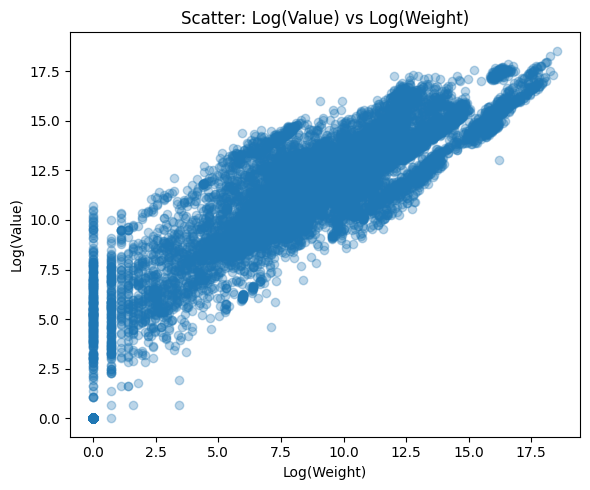

In [17]:
# log 변환된 값으로 산점도 그리기
# df_plot에도 log 변환 적용 (df_clean에서 이미 변환된 경우 그대로 사용)
if 'log_weight' not in df_plot.columns:
    for col in ['value', 'weight', 'quantity']:
        df_plot[f'log_{col}'] = np.log1p(df_plot[col])

plt.figure(figsize=(6, 5))
plt.scatter(df_plot['log_weight'], df_plot['log_value'], alpha=0.3)
plt.xlabel("Log(Weight)")
plt.ylabel("Log(Value)")
plt.title("Scatter: Log(Value) vs Log(Weight)")
plt.tight_layout()
plt.show()


In [18]:
from sklearn.ensemble import IsolationForest
import numpy as np

# df_clean에 log 변환이 없으면 먼저 적용
if 'log_weight' not in df_clean.columns:
    for col in ['value', 'weight', 'quantity']:
        df_clean[f'log_{col}'] = np.log1p(df_clean[col])

# 사용할 feature (log를 쓰면 더 안정적)
X = df_clean[['log_weight', 'log_value']].values

# 모델 (contamination: 이상치 비율, 조절 가능)
iso = IsolationForest(contamination=0.005, random_state=42)
df_clean['is_outlier_iso'] = iso.fit_predict(X)

# -1 → 이상치, 1 → 정상
df_out_iso = df_clean[df_clean['is_outlier_iso'] == -1]
df_norm_iso = df_clean[df_clean['is_outlier_iso'] == 1]

print("Detected outliers (ISO):", len(df_out_iso))
if len(df_out_iso) > 0:
    print(df_out_iso[['item_id','year','month','weight','value','quantity']].head())
else:
    print("이상치가 탐지되지 않았습니다.")


Detected outliers (ISO): 55
      item_id  year  month      weight       value  quantity
17   ATLDMDBO  2022      1  68878617.0  60548596.0       0.0
27   LRVGFDFM  2022      1  50311676.0  49185609.0       0.0
92   ATLDMDBO  2022      1  58061763.0  50308132.0       0.0
173  ATLDMDBO  2022      1  36368068.0  32240449.0       0.0
257  ATLDMDBO  2022      2  70474476.0  63846719.0       0.0


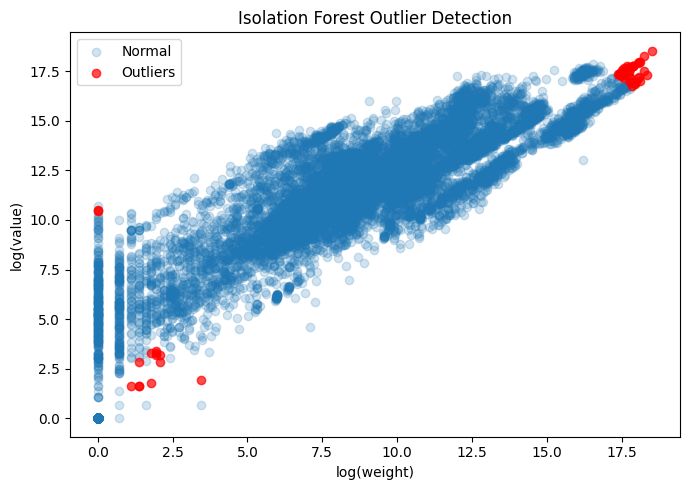

In [19]:
plt.figure(figsize=(7,5))
plt.scatter(df_norm_iso['log_weight'], df_norm_iso['log_value'], alpha=0.2, label='Normal')
plt.scatter(df_out_iso['log_weight'], df_out_iso['log_value'], color='red', alpha=0.7, label='Outliers')
plt.xlabel("log(weight)")
plt.ylabel("log(value)")
plt.title("Isolation Forest Outlier Detection")
plt.legend()
plt.tight_layout()
plt.show()


## 4-2. value vs quantity 산점도

- quantity가 클수록 value도 같이 커지는지 여부 확인


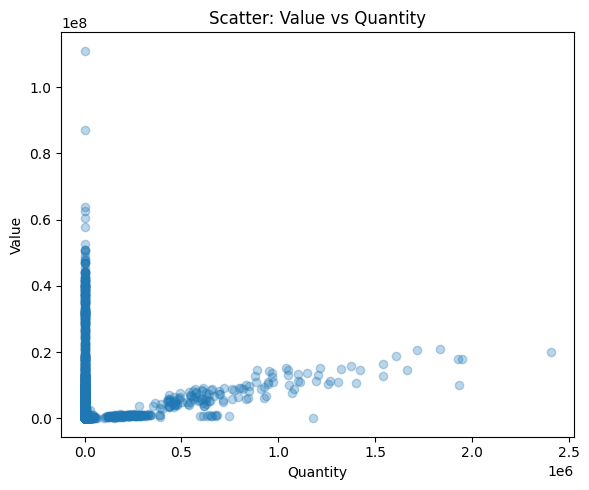

In [20]:
plt.figure(figsize=(6, 5))
plt.scatter(df_plot['quantity'], df_plot['value'], alpha=0.3)
plt.xlabel("Quantity")
plt.ylabel("Value")
plt.title("Scatter: Value vs Quantity")
plt.tight_layout()
plt.show()


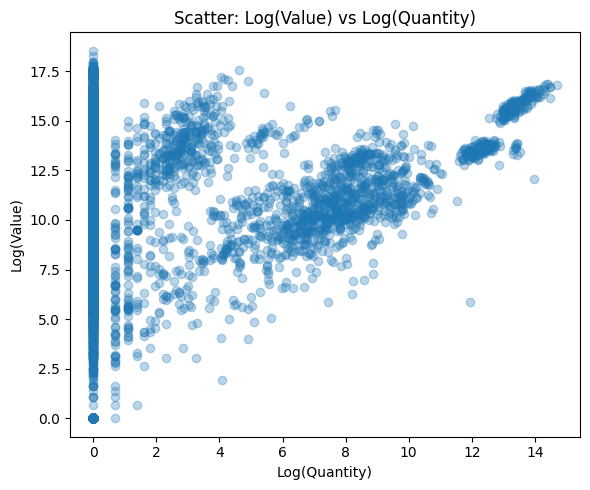

In [21]:
# log 변환된 값으로 산점도 그리기
# df_plot에도 log 변환 적용 (df_clean에서 이미 변환된 경우 그대로 사용)
if 'log_quantity' not in df_plot.columns:
    for col in ['value', 'weight', 'quantity']:
        df_plot[f'log_{col}'] = np.log1p(df_plot[col])

plt.figure(figsize=(6, 5))
plt.scatter(df_plot['log_quantity'], df_plot['log_value'], alpha=0.3)
plt.xlabel("Log(Quantity)")
plt.ylabel("Log(Value)")
plt.title("Scatter: Log(Value) vs Log(Quantity)")
plt.tight_layout()
plt.show()

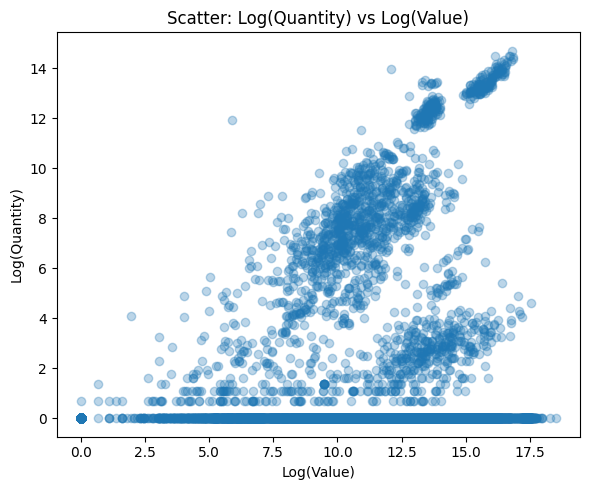

In [22]:
# log 변환된 값으로 산점도 그리기 (다른 각도)
# df_plot에도 log 변환 적용 (df_clean에서 이미 변환된 경우 그대로 사용)
if 'log_quantity' not in df_plot.columns:
    for col in ['value', 'weight', 'quantity']:
        df_plot[f'log_{col}'] = np.log1p(df_plot[col])

plt.figure(figsize=(6, 5))
plt.scatter(df_plot['log_value'], df_plot['log_quantity'], alpha=0.3)
plt.xlabel("Log(Value)")
plt.ylabel("Log(Quantity)")
plt.title("Scatter: Log(Quantity) vs Log(Value)")
plt.tight_layout()
plt.show()

## 4-3. weight vs quantity 산점도

- weight와 quantity의 관계를 확인


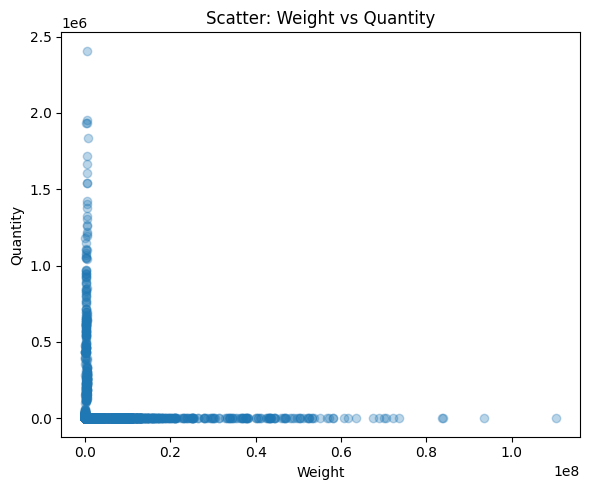

In [23]:
plt.figure(figsize=(6, 5))
plt.scatter(df_plot['weight'], df_plot['quantity'], alpha=0.3)
plt.xlabel("Weight")
plt.ylabel("Quantity")
plt.title("Scatter: Weight vs Quantity")
plt.tight_layout()
plt.show()


## 4-4. log 변환 및 요약 통계

- value, weight, quantity에 log1p 변환 적용
- 스케일 차이가 큰 값들을 다루기 쉽게 만들고
- 이후 상관분석에 활용


In [24]:
# df와 df_clean 모두에 log 변환 적용
for col in ['value', 'weight', 'quantity']:
    if f'log_{col}' not in df.columns:
        df[f'log_{col}'] = np.log1p(df[col])
    if f'log_{col}' not in df_clean.columns:
        df_clean[f'log_{col}'] = np.log1p(df_clean[col])

print("[log 변환 후 요약 통계 - 원본 df]")
print(df[['log_value', 'log_weight', 'log_quantity']].describe())

print("\n[log 변환 후 요약 통계 - 정제된 df_clean]")
print(df_clean[['log_value', 'log_weight', 'log_quantity']].describe())


[log 변환 후 요약 통계 - 원본 df]
          log_value    log_weight  log_quantity
count  10836.000000  10836.000000  10836.000000
mean      10.987703      8.493306      1.147952
std        4.024882      4.501891      2.934512
min        0.000000      0.000000      0.000000
25%        9.350776      5.848603      0.000000
50%       11.736133      8.784698      0.000000
75%       13.854505     11.954477      0.000000
max       18.525414     18.520453     20.490828

[log 변환 후 요약 통계 - 정제된 df_clean]
          log_value    log_weight  log_quantity
count  10835.000000  10835.000000  10835.000000
mean      10.987480      8.493345      1.146167
std        4.025001      4.502097      2.928757
min        0.000000      0.000000      0.000000
25%        9.350580      5.847882      0.000000
50%       11.735829      8.784928      0.000000
75%       13.854576     11.954514      0.000000
max       18.525414     18.520453     14.694147


## 4-5. raw 값 / log 값 상관계수 및 히트맵

- value, weight, quantity의 피어슨 상관계수 계산
- log 변환 후에도 다시 상관계수 계산
- 간단한 heatmap으로 시각화


[Raw Pearson Correlation]
             value    weight  quantity
value     1.000000  0.670956 -0.000050
weight    0.670956  1.000000 -0.002299
quantity -0.000050 -0.002299  1.000000

[Log1p Pearson Correlation]
              log_value  log_weight  log_quantity
log_value      1.000000    0.877453      0.108709
log_weight     0.877453    1.000000      0.039114
log_quantity   0.108709    0.039114      1.000000


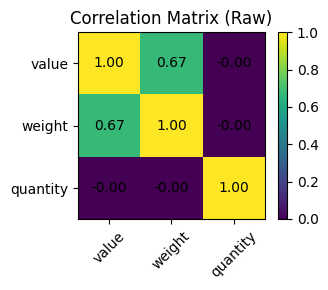

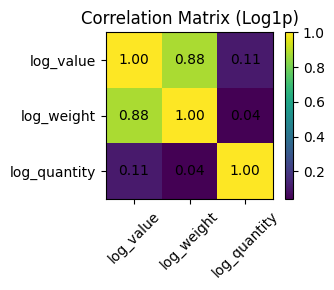

In [25]:
corr_raw = df[['value', 'weight', 'quantity']].corr(method='pearson')
corr_log = df[['log_value', 'log_weight', 'log_quantity']].corr(method='pearson')

print("[Raw Pearson Correlation]")
print(corr_raw)

print("\n[Log1p Pearson Correlation]")
print(corr_log)

def plot_corr_matrix(corr, title):
    plt.figure(figsize=(4, 3))
    im = plt.imshow(corr.values, interpolation='nearest')
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=45)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title(title)
    for i in range(len(corr.columns)):
        for j in range(len(corr.columns)):
            text = f"{corr.values[i, j]:.2f}"
            plt.text(j, i, text, ha="center", va="center")
    plt.tight_layout()
    plt.show()

plot_corr_matrix(corr_raw, "Correlation Matrix (Raw)")
plot_corr_matrix(corr_log, "Correlation Matrix (Log1p)")


## 4-6. Outlier 후보 탐지 및 시각화

- 예시 1: value=0인데 weight>0 또는 quantity>0인 경우
- 예시 2: log_value 상위 0.5% 극단값
- Outlier를 산점도에서 강조하여 표시


[value=0 이지만 weight>0 또는 quantity>0 인 행 개수]: 1
       item_id  year  month  weight  quantity  value
9288  WHPUAOID  2025      1     1.0       1.0    0.0

[Value 상위 0.5% Outlier 후보 개수]: 55


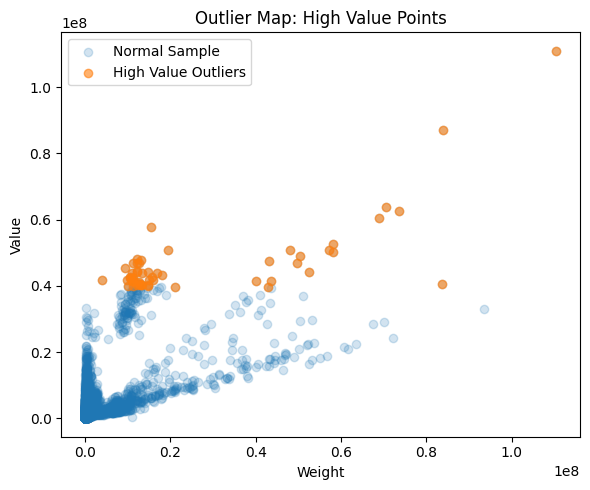

In [26]:
# value=0 이지만 weight>0 또는 quantity>0
mask_v0_wq_pos = (df['value'] == 0) & ((df['weight'] > 0) | (df['quantity'] > 0))
outlier_v0 = df[mask_v0_wq_pos]

print("[value=0 이지만 weight>0 또는 quantity>0 인 행 개수]:", len(outlier_v0))
if len(outlier_v0) > 0:
    print(outlier_v0[['item_id', 'year', 'month', 'weight', 'quantity', 'value']].head())

# log_value 상위 0.5% Outlier
# log 변환이 없으면 먼저 적용
if 'log_value' not in df.columns:
    for col in ['value', 'weight', 'quantity']:
        df[f'log_{col}'] = np.log1p(df[col])

upper_q = df['log_value'].quantile(0.995)
high_value_outlier = df[df['log_value'] >= upper_q]
print("\n[Value 상위 0.5% Outlier 후보 개수]:", len(high_value_outlier))

# Outlier 시각화: Value vs Weight
plt.figure(figsize=(6, 5))
plt.scatter(df_plot['weight'], df_plot['value'], alpha=0.2, label='Normal Sample')
plt.scatter(high_value_outlier['weight'], high_value_outlier['value'],
            alpha=0.6, label='High Value Outliers')
plt.xlabel("Weight")
plt.ylabel("Value")
plt.title("Outlier Map: High Value Points")
plt.legend()
plt.tight_layout()
plt.show()
